## 1. 필요한 패키지 불러오기

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math


import warnings
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error

## 2. 필요한 데이터 불러오기

분석할 데이터는 Yahoo Financial에서 가져온 마이크로소프트의 1년간 일별 주가 정보입니다.

In [2]:
# 이번에는 Date를 index_col로 지정해 주었습니다. 
df = pd.read_csv("./data/MSFT.csv", index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-18,213.649994,215.169998,210.929993,211.080002,209.708328,28372800
2020-11-19,211.380005,213.029999,209.929993,212.419998,211.039627,24792700
2020-11-20,212.199997,213.289993,210.000000,210.389999,209.022812,22843100
2020-11-23,210.949997,212.289993,208.160004,210.110001,208.744629,25683500
2020-11-24,209.589996,214.250000,208.860001,213.860001,212.470261,33979700


## 3. 데이터 전처리 및 시각화

ARIMA 모델로 예측할 주가 정보는 일별 종가로 선택하겠습니다.

In [3]:
ts1 = df['Close'] 
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
2020-11-18    211.080002
2020-11-19    212.419998
2020-11-20    210.389999
2020-11-23    210.110001
2020-11-24    213.860001
Name: Close, dtype: float64

### 3.1 현재 데이터 plot

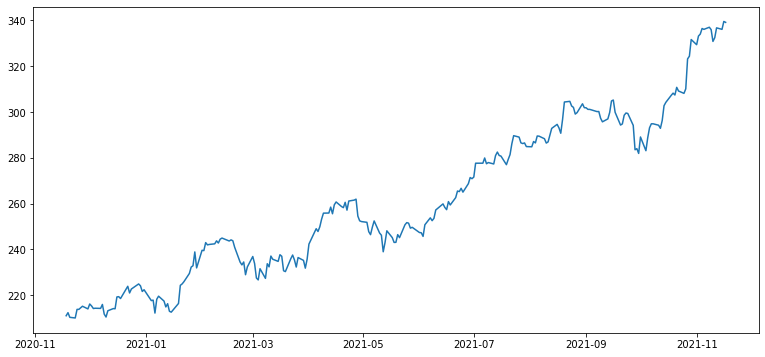

In [4]:
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.
plt.plot(ts1)

### 3.2 결측값 제거

만약 결측치가 있다면, 두가지 방법으로 결측치를 처리해 줄 수 있습니다.

1. 결측치가 있는 데이터를 모두 삭제(drop)

2. 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입
ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

In [5]:
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

가져온 데이터에서는 결측값이 발견되지 않았기 때문에 따로 새로운 전처리를 하지는 않겠습니다.

### 3.3 이동평균, 이동표준편차 시각화

해당 데이터는 12개월 기준의 데이터이기 때문에 window를 12로 주는 것이 추세성을 반영할 수 있을 것 입니다.

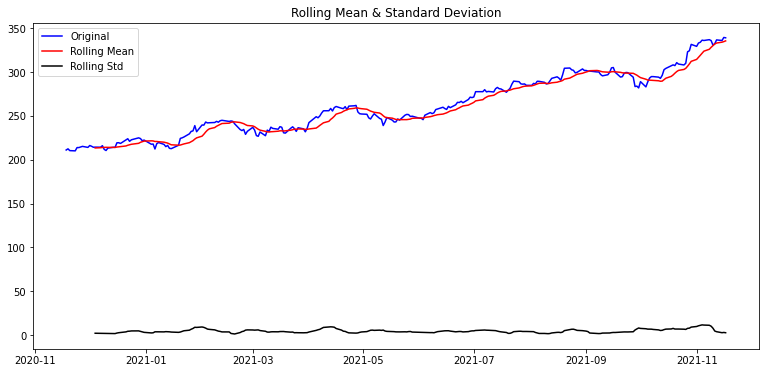

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


plot_rolling_statistics(ts1, window=12)

### 3.4 Augmented Dickey-Fuller Test

1. 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
3. 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다는 내용입니다.

In [7]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   0.232595
p-value                          0.974032
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


Augmented Dickey-Fuller Test의 결과 p-value가 0.974032로 유의확률인 0.05보다 훨씬 크기 때문에 해당 데이터는 정상성을 가지지 못한다는 귀무가설을 채택하게 됩니다.

저희들이 원하는 상황은 귀무가설을 기각하고 정상성을 만족하는 대립가설을 채택해야하기 때문에 데이터를 정상성을 가지도록 가공을 하거나 시계열 분해 기법을 적용해야 합니다.

### 3.5 안정성을 가지도록 데이터 가공

1. 정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도

#### 로그 변환

Results of Dickey-Fuller Test:
Test Statistic                  -0.210737
p-value                          0.937230
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


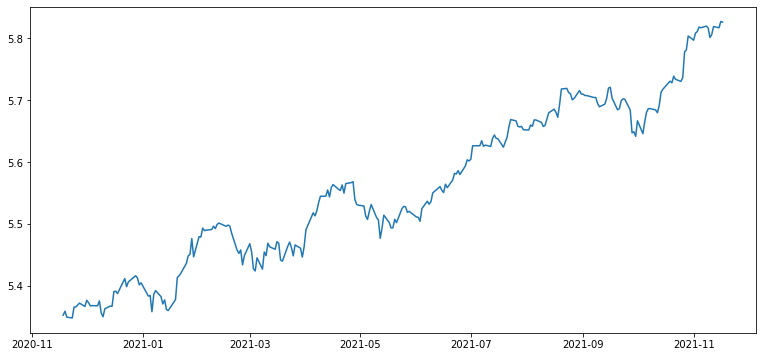

In [8]:
ts_log = np.log(ts1)
plt.plot(ts_log)

augmented_dickey_fuller_test(ts_log)

로그변환을 한 후 augmented_dickey_fuller_test를 한 p-value가 0.974302에서 0.937230으로 감소하기는 하였지만 아직도 유의확률 0.05보다는 훨씬 크기 때문에 추가적인 가공이 필요합니다.

#### 이동 평균을 제거하여 추세성 상쇄

Date
2020-11-18         NaN
2020-11-19         NaN
2020-11-20         NaN
2020-11-23         NaN
2020-11-24         NaN
2020-11-25         NaN
2020-11-27         NaN
2020-11-30         NaN
2020-12-01         NaN
2020-12-02         NaN
2020-12-03         NaN
2020-12-04    0.004369
2020-12-07    0.002784
2020-12-08    0.009382
2020-12-09   -0.010857
Name: Close, dtype: float64

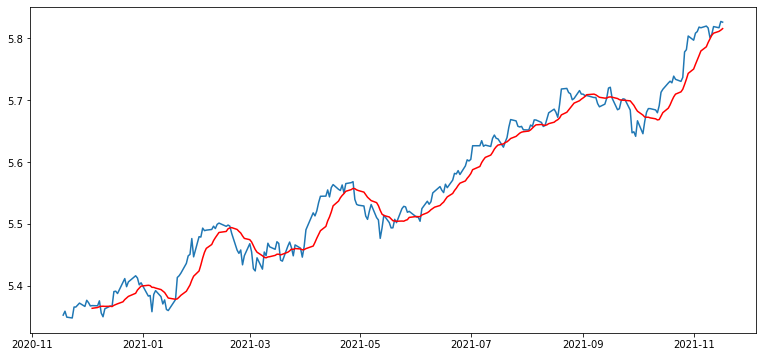

In [9]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

이동평균을 제거하며 생긴 결측값들은 제거하고 다시 Augmented Dickey-Fuller Test을 시도하겠습니다.

Date
2020-12-04    0.004369
2020-12-07    0.002784
2020-12-08    0.009382
2020-12-09   -0.010857
2020-12-10   -0.017081
2020-12-11   -0.003915
2020-12-14    0.000354
2020-12-15    0.000454
2020-12-16    0.022217
2020-12-17    0.021627
2020-12-18    0.016600
2020-12-21    0.031548
2020-12-22    0.033951
2020-12-23    0.018249
2020-12-24    0.023485
Name: Close, dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -4.748514
p-value                          0.000068
#Lags Used                       8.000000
Number of Observations Used    232.000000
Critical Value (1%)             -3.458855
Critical Value (5%)             -2.874080
Critical Value (10%)            -2.573453
dtype: float64


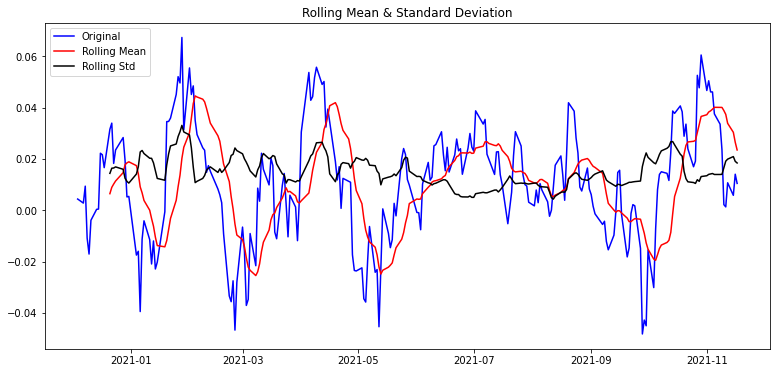

In [10]:
ts_log_moving_avg.dropna(inplace=True)
print(ts_log_moving_avg.head(15))
print("\n")
augmented_dickey_fuller_test(ts_log_moving_avg)
plot_rolling_statistics(ts_log_moving_avg)

기존 데이터에 로그변환을 하고 이동 평균을 빼서 다시 augmented_dickey_fuller_test를 한 결과 p-value가 0.93에서 0.000068로 확실히 감소하였고 0.05보다 작아졌기 때문에 가공된 데이터의 정상성이 보장되는 대립가설을 채택할 수 있게 되었습니다.

#### 차분하여 계절성 상쇄

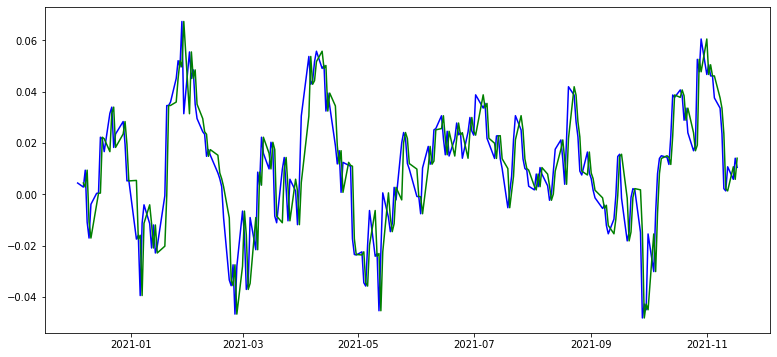

In [11]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

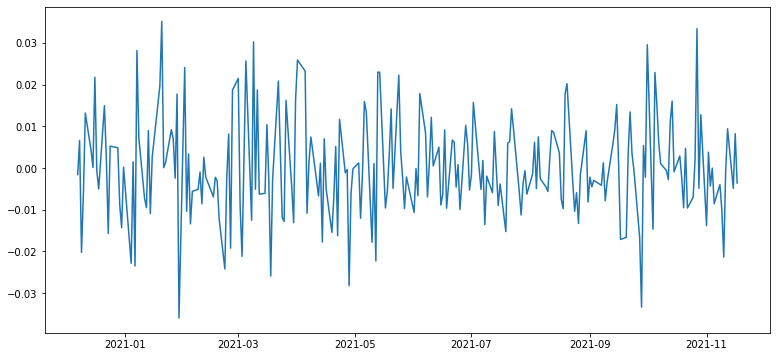

In [12]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

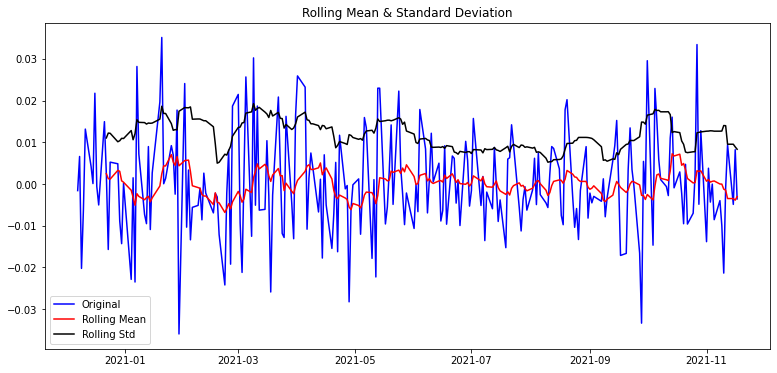

In [13]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [14]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.934513e+00
p-value                        3.442109e-12
#Lags Used                     3.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


2. 시계열 분해(Time series decomposition) 기법을 적용

#### 에러 발생
- ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [15]:
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

해당 error는 가져온 데이터의 날짜사이에 빠져있는 날이 생겨서 발생하는 에러로 판단됩니다. 

아래의 head() 함수로 나온 값과 같이 2020-11-22, 2020-11-28 등이 빠져 있는 날짜가 존재합니다. 

In [16]:
ts_log.head(20)

Date
2020-11-18    5.352237
2020-11-19    5.358565
2020-11-20    5.348963
2020-11-23    5.347631
2020-11-24    5.365322
2020-11-25    5.365368
2020-11-27    5.371707
2020-11-30    5.366303
2020-12-01    5.376250
2020-12-02    5.372357
2020-12-03    5.367097
2020-12-04    5.367657
2020-12-07    5.367330
2020-12-08    5.375325
2020-12-09    5.355642
2020-12-10    5.349581
2020-12-11    5.362512
2020-12-14    5.366910
2020-12-15    5.366583
2020-12-16    5.390349
Name: Close, dtype: float64

이러한 결측값들은 보간법을 사용하여 채워주겠습니다.

In [17]:
tmp1 = ts_log.reset_index()
tmp2 = pd.DataFrame(index = pd.date_range('11/18/2020', '11/17/2021')).reset_index()
tmp2.columns = ["Date"]
new_ts_log = tmp2.merge(tmp1, how = "outer")
new_ts_log = new_ts_log.set_index("Date")
print(f"보간법 하기 전 결측값 개수 : {new_ts_log.isna().sum()}")
new_ts_log = new_ts_log.interpolate(method='time')
print(f"보간법 한 후 결측값 개수 : {new_ts_log.isna().sum()}")

보간법 하기 전 결측값 개수 : Close    113
dtype: int64
보간법 한 후 결측값 개수 : Close    0
dtype: int64


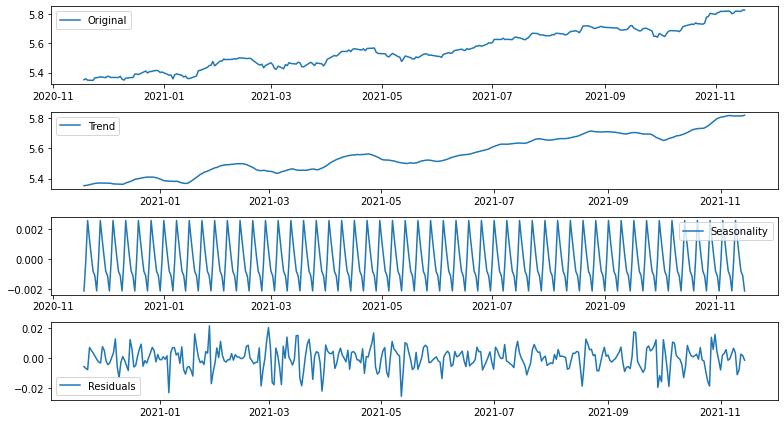

In [18]:
decomposition = seasonal_decompose(new_ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

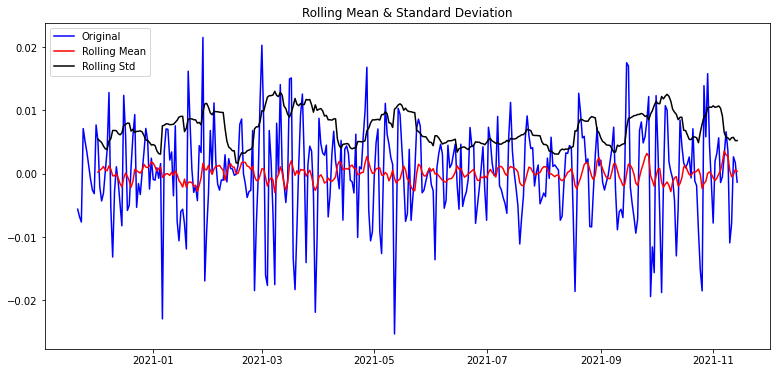

In [19]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [20]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.069551e+01
p-value                        3.633499e-19
#Lags Used                     8.000000e+00
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


이전에 직접 추세성과 계설성을 상쇄시킨 p-value값과 비슷해졌으므로 0.05보다 작기 때문에 귀무가설을 기각하고 대립가설을 채택하게 되어서 해당 데이터는 정상성을 가지고 있다고 할 수 있습니다.

## 4. ARIMA 모델 구축

### 4.1 p, d, q 모수설정

ARIMA의 적절한 모수 p, d, q를 선택하는 방법으로 많은 통계학적인 시도들이 있지만 대표적인 것만 이야기하면 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)를 말할 수 있습니다. 
- p : 자기회귀 모형(AR)의 시차
- q : 이동평균 모형(MA)의 시차
- d : 차분 누적(I) 횟수

#### 직접 차분하여 모수 d 구하기

d를 구하기 위해서는 좀 다른 접근이 필요합니다. d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.857865e+01
p-value                        2.079014e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.630000e+02
Critical Value (1%)           -3.448494e+00
Critical Value (5%)           -2.869535e+00
Critical Value (10%)          -2.571029e+00
dtype: float64


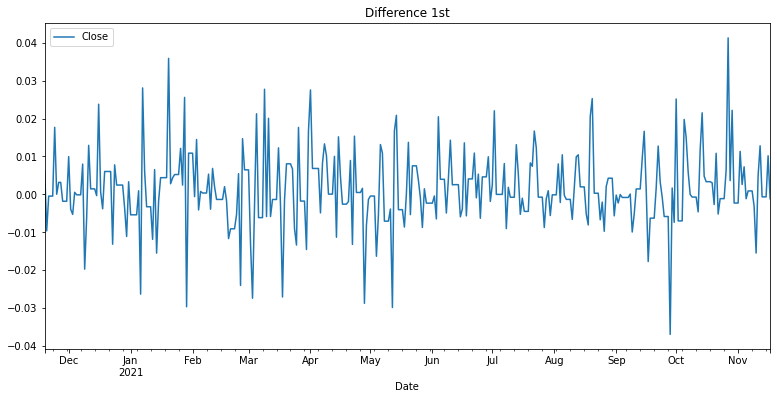

In [21]:
# 1차 차분 구하기
diff_1 = new_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분을 하여도 아직 상승 곡선을 그리는 구간이 존재하며 이 말은 추세성 및 계절성이 존재한다는 의미입니다.

이를 상쇄시키기 위해서 1차 차분한 값을 한번 더 차분하여 2차 차분을 진행하겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -8.669361e+00
p-value                        4.590932e-14
#Lags Used                     1.300000e+01
Number of Observations Used    3.490000e+02
Critical Value (1%)           -3.449227e+00
Critical Value (5%)           -2.869857e+00
Critical Value (10%)          -2.571201e+00
dtype: float64


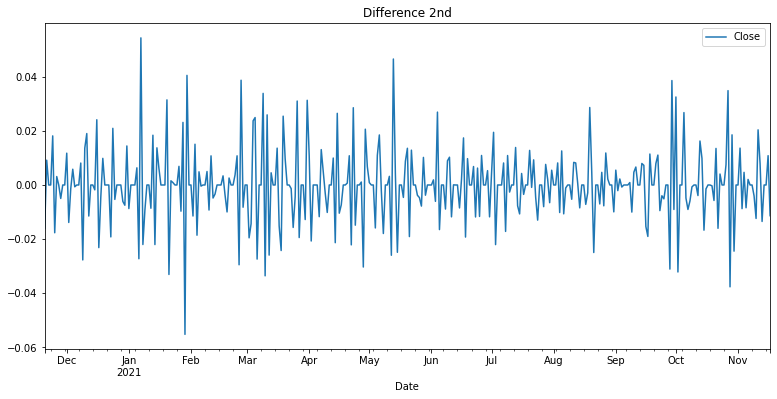

In [22]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

모수 d는 2번 차분하였을 때가 가장 안정성이 있는 상태라고 볼 수 있습니다.

#### ACF(자기상관함수)로 모수 q 정하기

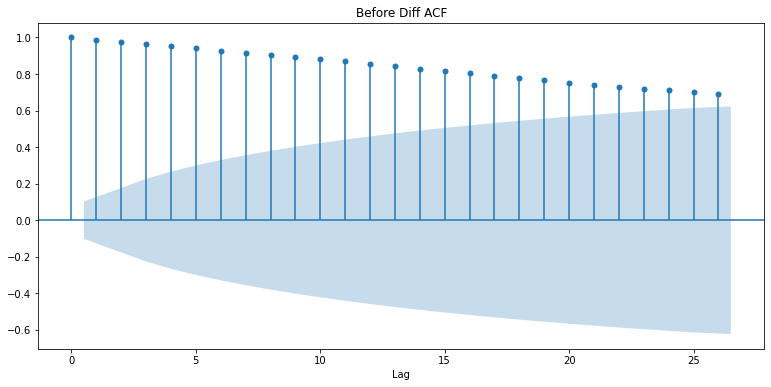

In [23]:
plot_acf(new_ts_log)   # ACF : Autocorrelation 그래프 그리기
plt.title("Before Diff ACF")
plt.xlabel("Lag")
plt.show()

차분하기 전의 ACF는 위와 같습니다.

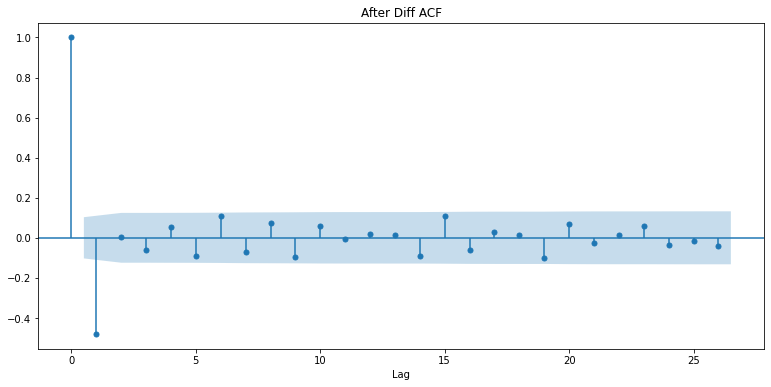

In [24]:
plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plt.title("After Diff ACF")
plt.xlabel("Lag")
plt.show()

차분을 2번한 값을 ACF로 본 결과 기존의 데이터보다 차분을 한 데이터가 Lag 1 이후 부터는 훨씬 빠르게 0에 수렴하고 있는 것을 알 수 가 있습니다.

모수 q는 특정 차수이상에서 사라지는 부분을 선택해야 하므로 q = 1 으로 지정한 상태로 진행하겠습니다.

#### PACF(편자기상관함수)로 모수 p 정하기

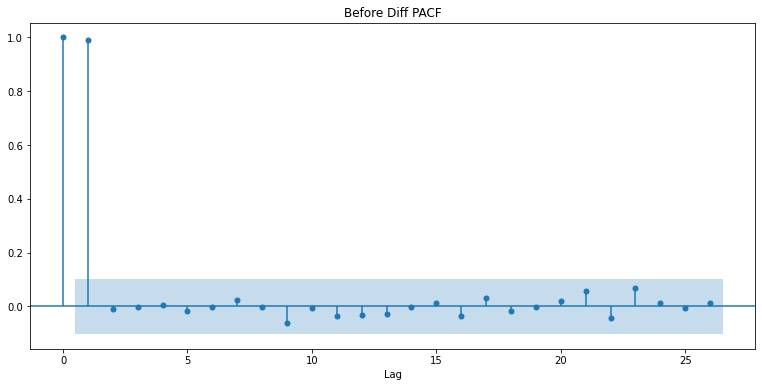

In [25]:
plot_pacf(new_ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.title("Before Diff PACF")
plt.xlabel("Lag")
plt.show()

차분하기 전의 PACF는 위와 같습니다.

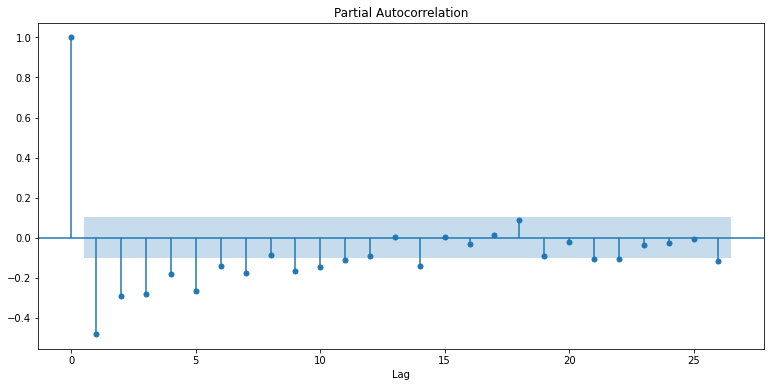

In [26]:
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.xlabel("After Diff PACF")
plt.xlabel("Lag")
plt.show()

차분을 2번한 값을 PACF로 본 결과 기존의 데이터보다 차분을 한 데이터가 Lag 10 이후 부터는 훨씬 빠르게 0에 수렴하고 있는 것을 알 수 가 있습니다.

모수 p는 특정 차수이상에서 사라지는 부분을 선택해야 하므로 p = 10 으로 지정한 상태로 진행하겠습니다.

결과적으로 지정한 모수의 값은 아래와 같습니다

- ARIMA 모델 모수 p = 10
- ARIMA 모델 모수 d = 2
- ARIMA 모델 모수 q = 1

### 4.2 훈련 데이터셋, 테스트 데이터셋 분리

훈련셋과 테스트셋의 비율을 9:1로 나누어주겠습니다.

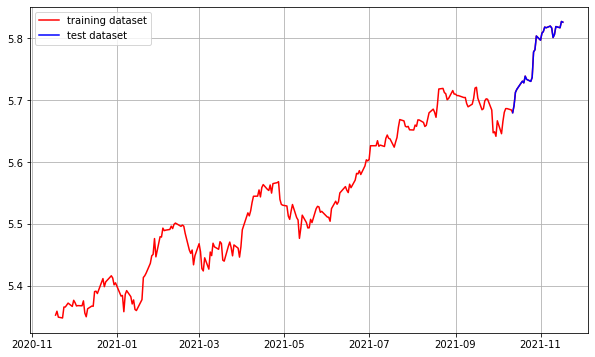

In [27]:
train_data, test_data = new_ts_log[:int(len(new_ts_log)*0.9)], new_ts_log[int(len(new_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [28]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-11-18    5.352237
2020-11-19    5.358565
Name: Close, dtype: float64
(328, 1)
(37, 1)


### 4.3 모델훈련과 추론

앞서 경험적으로 구한 차분 횟수와 ACF, PACF 그림을 통하여 구한 모수들 p, d, q를 기반으로 ARIMA 모델을 훈련하고 추론까지 해보겠습니다.

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  328
Model:                ARIMA(10, 2, 1)   Log Likelihood                1030.625
Date:                Thu, 18 Nov 2021   AIC                          -2037.250
Time:                        06:54:27   BIC                          -1991.807
Sample:                    11-18-2020   HQIC                         -2019.116
                         - 10-11-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1777      0.124     -1.430      0.153      -0.421       0.066
ar.L2         -0.2030      0.110     -1.839      0.066      -0.419       0.013
ar.L3         -0.2768      0.111     -2.491      0.0

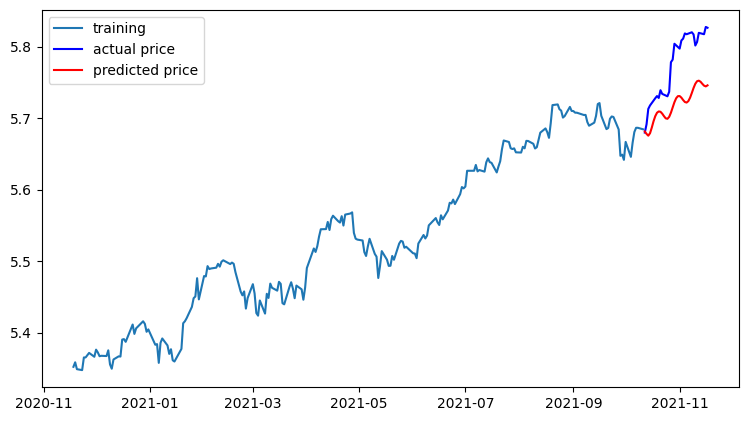

In [34]:
# Build Model
# order(p, d, q)
model = ARIMA(train_data, order=(10, 2, 1))
fitted_m = model.fit() 
print(fitted_m.summary())
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [30]:
# 평균제곱오차(MSE : Mean Squared Errors) : 실제값과 예측값 사이의 차이를 제곱한 값들의 평균
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

# 평균절대오차(MAE : Mean of Absolute Errors) : 실제값과 예측값 사이의 차이의 합을 예측 기간 수로 나눔
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

# 평균제곱오차제곱근(RMSE : Root Means of Squared Errors) : MSE의 제곱근
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

# 평균절대값퍼센트오차(MAPE : Mean of Absolute Percentage Errors) : 실제값에 대한 MAE 비율
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)["Close"])/np.abs(np.exp(test_data)["Close"]))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  396.53795330906985
MAE:  17.90825418957738
RMSE:  19.913260740247186
MAPE: 5.45%


ARIMA(10, 2, 1)인 모델로 test_data를 예측한 결과 어느 정도 상승하는 추세성은 따라가지만 급격히 올라가는 수치와는 조금 떨어져 있는 형태입니다.

모델의 성능 지표들을 확인한 결과 MAPE가 5.45% 로 기준치인 15% 보다 훨씬 낮은 수치가 나왔에 만족할 만한 성능이 나왔다고 판단하였습니다.

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  328
Model:                ARIMA(10, 2, 3)   Log Likelihood                1050.338
Date:                Thu, 18 Nov 2021   AIC                          -2072.676
Time:                        06:54:31   BIC                          -2019.660
Sample:                    11-18-2020   HQIC                         -2051.519
                         - 10-11-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7196      1.209     -0.595      0.552      -3.088       1.649
ar.L2         -0.5857      0.517     -1.134      0.257      -1.598       0.427
ar.L3         -0.5177      0.410     -1.261      0.2

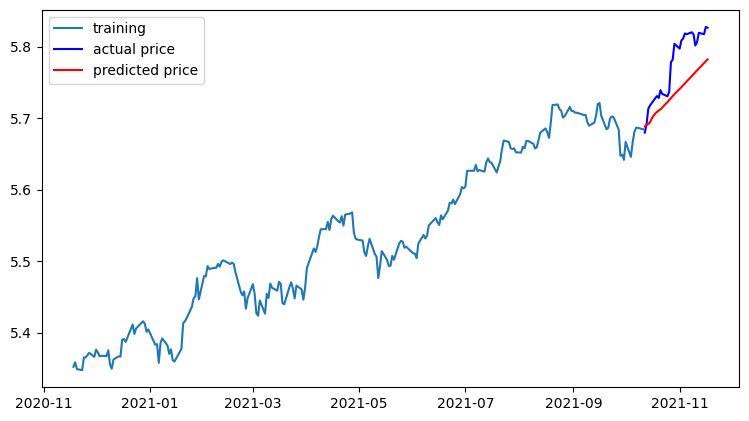

In [35]:
# Build Model
# order(p, d, q)
model = ARIMA(train_data, order=(10, 2, 3))
fitted_m = model.fit() 
print(fitted_m.summary())
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [32]:
# 평균제곱오차(MSE : Mean Squared Errors) : 실제값과 예측값 사이의 차이를 제곱한 값들의 평균
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

# 평균절대오차(MAE : Mean of Absolute Errors) : 실제값과 예측값 사이의 차이의 합을 예측 기간 수로 나눔
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

# 평균제곱오차제곱근(RMSE : Root Means of Squared Errors) : MSE의 제곱근
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

# 평균절대값퍼센트오차(MAPE : Mean of Absolute Percentage Errors) : 실제값에 대한 MAE 비율
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)["Close"])/np.abs(np.exp(test_data)["Close"]))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  209.51778555578642
MAE:  12.714432712317002
RMSE:  14.474729204920775
MAPE: 3.86%


경험적으로 q를 1에서 3으로 바꿔보면 MAPE가 3.86% 까지 내려가지만 예측 곡선의 굴곡짐은 사라지고 빠르게 올라가능 추세성만을 반영한 상태로 나오기에 성능은 좋지만 일반화가 되지 못한 모델이라고 판단됩니다.